<a href="https://colab.research.google.com/github/pfauda/python/blob/gh-pages/EstrategiaRSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Estrategia RSI con activos de alta volatilidad

In [ ]:
!pip install yfinance
!pip install mplfinance

     |████████████████████████████████| 5.5MB 11.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=f484a6c82c93c9d062cc6afe36da89e75967898f3fde6bec33aba5d26a2472f1
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 61kB 4.5MB/s 


In [ ]:
# Importar librerias
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc
import datetime

In [51]:
start = "2000-01-01"
end = dt.datetime.now().strftime("%Y-%m-%d")
variable = "Adj Close"

In [52]:
df_ccl_data = yf.download(['GGAL','GGAL.BA','YPF','YPFD.BA'], start=start, end=end)[variable]
df_ccl_pond =  df_ccl_data['YPFD.BA']/df_ccl_data['YPF']
df_ccl_pond += df_ccl_data['GGAL.BA']/df_ccl_data['GGAL'] * 10
df_ccl_pond /= 2
df_ccl_pond = df_ccl_pond.to_frame()
df_ccl_pond.rename(columns={ df_ccl_pond.columns[0]: variable }, inplace = True)

[*********************100%***********************]  4 of 4 completed


In [53]:
# Podar los outliers
removed_ol = df_ccl_pond[variable].between(close.quantile(.002), close.quantile(.998))
df_ccl_pond = df_ccl_pond[removed_ol] # without outliers
# Interpolar los valores eliminados y faltantes
df_ccl_pond.pad(inplace=True)

In [91]:
# Inicializaciones
#tickers = ["GGAL", "BMA", "SUPV", "BBAR"]
#tickers = ["BBAR"]
tickers = ["^MERV",
           "GGAL.BA", "BBAR.BA", "BMA.BA", "SUPV.BA", "BYMA.BA", "VALO.BA",
           "CVH.BA", "TECO2.BA", "MIRG.BA", "COME.BA",
           "CRES.BA",
           "ALUA.BA", "HARG.BA", "LOMA.BA", "TXAR.BA",  
           "EDN.BA", "TGSU2.BA", "TGNO4.BA", "PAMP.BA", "TRAN.BA", "YPFD.BA"]
precios = {} # diccionario para guardar los datos

# Importación de datos
for i in range(len(tickers)):
    precios[tickers[i]] = yf.download(tickers[i], start=start) #["Adj Close"].to_frame()
    precios[tickers[i]]["Open"] = precios[tickers[i]]["Open"] / df_ccl_pond[variable]
    precios[tickers[i]]["High"] = precios[tickers[i]]["High"] / df_ccl_pond[variable]
    precios[tickers[i]]["Close"] = precios[tickers[i]]["Close"] / df_ccl_pond[variable]
    precios[tickers[i]]["Low"] = precios[tickers[i]]["Low"] / df_ccl_pond[variable]
    precios[tickers[i]]["Adj Close"] = precios[tickers[i]]["Adj Close"] / df_ccl_pond[variable]
    precios[tickers[i]]["Volume"] = precios[tickers[i]]["Volume"] / df_ccl_pond[variable]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [93]:
def calc_rsi(ohlc: pd.DataFrame, period: int = 14, source: str = 'Close') -> pd.Series:
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = ohlc[source].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return pd.Series(100 - (100 / (1 + RS)), name="RSI")

In [94]:
# Cálculo RSI
price_dict = copy.deepcopy(precios)
for ticker in tickers:
    print("Calculando RSI de", ticker)
    price_dict[ticker]["RSI"] = calc_rsi(price_dict[ticker], 14, 'Adj Close')
    price_dict[ticker].dropna(inplace=True)

Calculando RSI de ^MERV
Calculando RSI de GGAL.BA
Calculando RSI de BBAR.BA
Calculando RSI de BMA.BA
Calculando RSI de SUPV.BA
Calculando RSI de BYMA.BA
Calculando RSI de VALO.BA
Calculando RSI de CVH.BA
Calculando RSI de TECO2.BA
Calculando RSI de MIRG.BA
Calculando RSI de COME.BA
Calculando RSI de CRES.BA
Calculando RSI de ALUA.BA
Calculando RSI de HARG.BA
Calculando RSI de LOMA.BA
Calculando RSI de TXAR.BA
Calculando RSI de EDN.BA
Calculando RSI de TGSU2.BA
Calculando RSI de TGNO4.BA
Calculando RSI de PAMP.BA
Calculando RSI de TRAN.BA
Calculando RSI de YPFD.BA


In [95]:
def plot_chart(data, n, ticker, sobreVenta, sobreCompra):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((18, 7))
    #ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ##ax_macd  = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    #ax_rsi    = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    #ax_vol    = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    ax_candle = fig.add_axes((0, 1.00, 1, 0.50))
    ax_rsi    = fig.add_axes((0, 0.75, 1, 0.20), sharex=ax_candle)
    ax_vol    = fig.add_axes((0, 0.50, 1, 0.20), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    ## Plot candlestick chart
    #ax_candle.plot(data.index, data["ma10"], label="MA10")
    #ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    #ax_candle.legend()
    
    ## Plot MACD
    #ax_macd.plot(data.index, data["macd"], label="macd")
    #ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    #ax_macd.plot(data.index, data["macd_signal"], label="signal")
    #ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [sobreCompra] * len(data.index), label="S.Compra")
    ax_rsi.plot(data.index, [sobreVenta] * len(data.index), label="S.Venta")
    ax_rsi.plot(data.index, data["RSI"], label="RSI")
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000)
    ax_vol.set_ylabel("(En miles)")
   
    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()

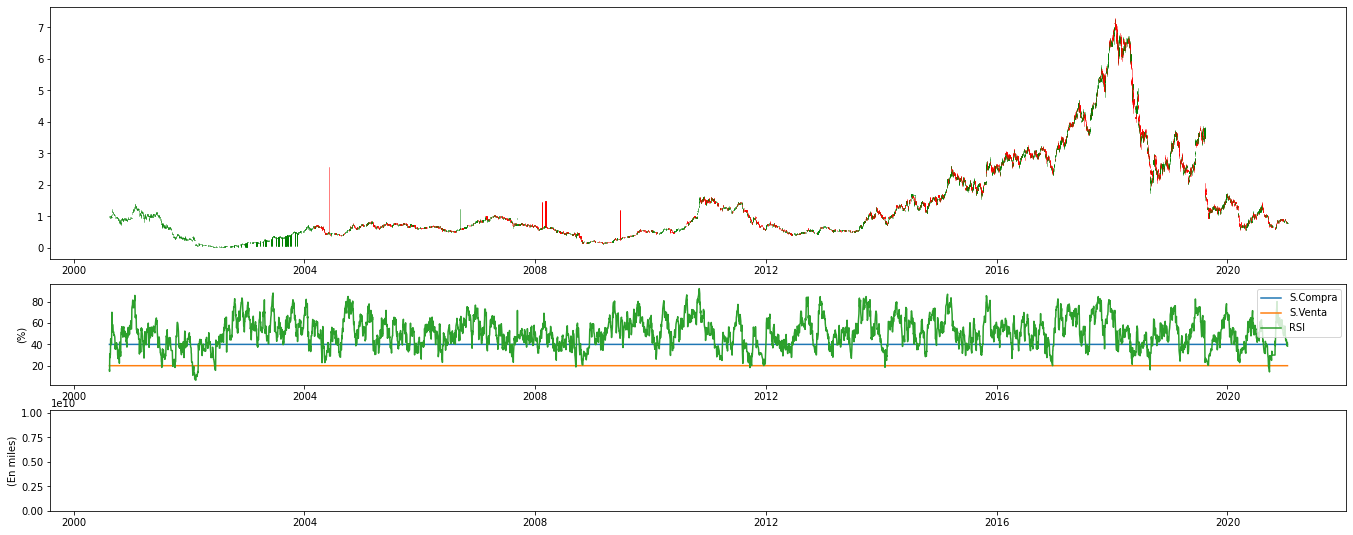

In [96]:
plot_chart(price_dict["GGAL.BA"], 7000, ticker, 20, 40)

In [66]:
class Strategy:

  def __init__(self, data, capital, source):
    self.data = data
    self.capital = capital
    self.source = source
    self.date_buy = data.index[0]
    self.date_close = data.index[0]
    self.days = 0
    self.profit_abs = 0
    self.profit_prc = 0
    self.cum_profit_abs = 0
    self.cum_profit_prc = 0

    self.trades = pd.DataFrame(columns = ['date_buy', 'date_close', 'days', 
                                          'price_buy', 'price_close', 'shares',
                                          'profit_abs', 'profit_prc',
                                          'cum_profit_abs', 'cum_profit_prc'])
    self.entry_id = ""
    #self.balance = []
    #self.summary = pd.DataFrame(columns = ["ret", "ret_cum", "max", "drowdown"])
    self.len = len(data) - 1
    self.entry_candle = 0

  #def compute_tick(self, i):
  #  if self.entry_id == "":
  #    self.balance.append(0)
  #  else:
  #    self.balance.append((self.data['Close'][self.entry_candle]/self.data[self.source][i-1])-1)

  def entry(self, entry_id, i):
    if self.entry_id != entry_id:
      if i < self.len:
        self.entry_candle = i
        self.entry_id = entry_id
        self.date_buy = self.data.index[i+1]
        # Para comprar se toma el precio de cierre del dia anterior
        self.shares_old = int( ( self.capital + self.cum_profit_abs ) / self.data['Close'][i] )

  def close_all(self, i):
    if self.entry_id != "":
      if i < self.len:
        self.entry_id = ""
        self.date_close = self.data.index[i+1]
        self.days = (self.date_close - self.date_buy).days
        # Para el calculo de la ganancia tomar el precio de apertura de la estrategia del dia siguiente
        self.profit_abs = self.shares_old * ( self.data['Open'][i+1] - self.data['Open'][self.entry_candle+1] )
        self.profit_prc = (self.data['Open'][i+1] / self.data['Open'][self.entry_candle+1] - 1)
        self.cum_profit_abs += self.profit_abs
        self.cum_profit_prc += self.profit_prc
        self.trades = self.trades.append({'date_buy': self.date_buy,
                                          'date_close': self.date_close,
                                          'days': self.days,
                                          'price_buy': self.data['Open'][self.entry_candle+1],
                                          'price_close': self.data['Open'][i+1],
                                          'shares': self.shares_old,
                                          'profit_abs': self.profit_abs,
                                          'profit_prc': self.profit_prc,
                                          'cum_profit_abs': self.cum_profit_abs,
                                          'cum_profit_prc': self.cum_profit_prc},
                                          ignore_index=True)
        self.shares_old = 0
        self.entry_candle = 0

  def end(self, i):
    self.close_all(i)

  def print_report(self):
    if len(self.trades) > 0:
      pd.set_option("display.max_rows", None, "display.max_columns", 200)
      print('\nTrades realizados')
      print('-------------------------------------------------------------------------')
      print(self.trades)
      print('-------------------------------------------------------------------------')
      print("\nGanancia acumulada")
      print(round(self.cum_profit_abs, 2))

      print(f'\nLa ganancia promedio es de {round(self.trades["profit_prc"].mean()*100, 2)}%')
      print(f'La desviación estandar del resultado es de {round(self.trades["profit_prc"].std()*100, 2)}%')
      print(f'La duración promedio es de {round(self.trades["days"].mean(), 2)} días')
      print(f'El {round((len(self.trades[self.trades["profit_prc"]>0])/len(self.trades))*100, 2)}% de las veces se sale con ganancias')
      print(f'El {round((len(self.trades[self.trades["profit_prc"]<=0])/len(self.trades))*100, 2)}% de las veces se sale con perdidas')
      print(f'El peor resultado al cierre fue de {round(self.trades["profit_prc"].min()*100, 2)}%')
      print(f'El mejor resultado al cierre fue de {round(self.trades["profit_prc"].max()*100, 2)}%')

      #self.summary["ret"] = np.array(self.balance)
      #self.summary["ret_cum"] = (1+self.summary["ret"]).cumprod()

      #print("\nbajas durante la estrategia")
      #self.summary["max"] = self.summary["ret_cum"].cummax()
      #self.summary["drowdown"] = self.summary["ret_cum"] / self.summary["max"] -1
      #print(f'baja máxima de {round(self.summary["drowdown"].min()*100, 2)}%')

    # RSI Actuales
    print("\nRSI actuales")
    print(round(self.data["RSI"][-1], 2))

  def get_result(self):
    return self.cum_profit_abs

In [67]:
def calc_strategy_rsi(data, sobreVenta, sobreCompra, source) -> float:

  strategy = Strategy(data, 100000, source)

  for i in range(len(data)):
    #strategy.compute_tick(i)
    if data["RSI"][i]<sobreVenta:
        strategy.entry("Compra", i)
    if data["RSI"][i]>=sobreCompra:
        strategy.close_all(i)
  
  strategy.end(i)
  #strategy.print_report()
  ganancia = strategy.get_result()
  del strategy

  return ganancia


Calculando estrategia para  ^MERV
26 32 168591.82499768594


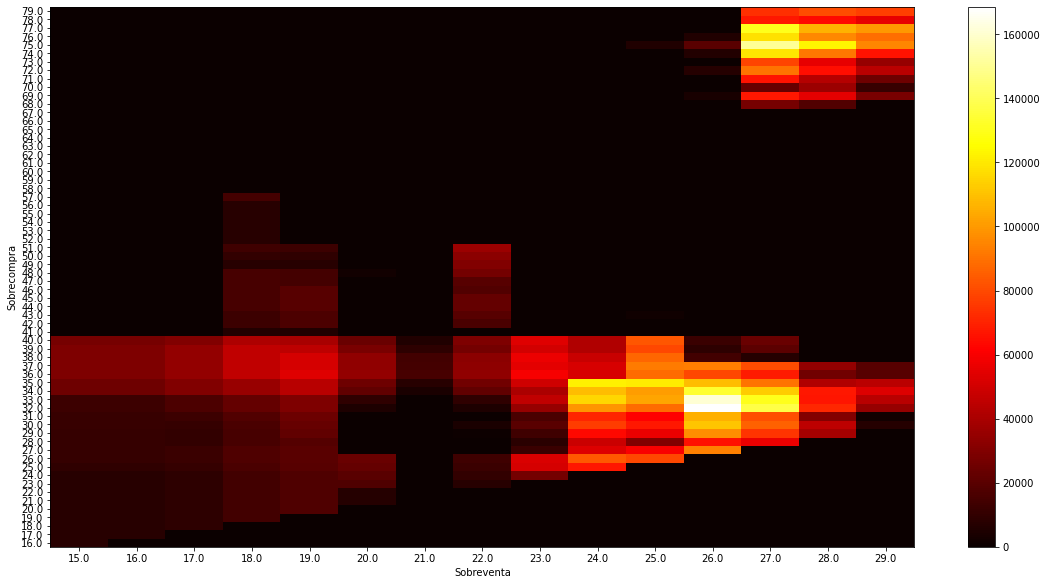


Calculando estrategia para  GGAL.BA
21 50 269435.4429094865


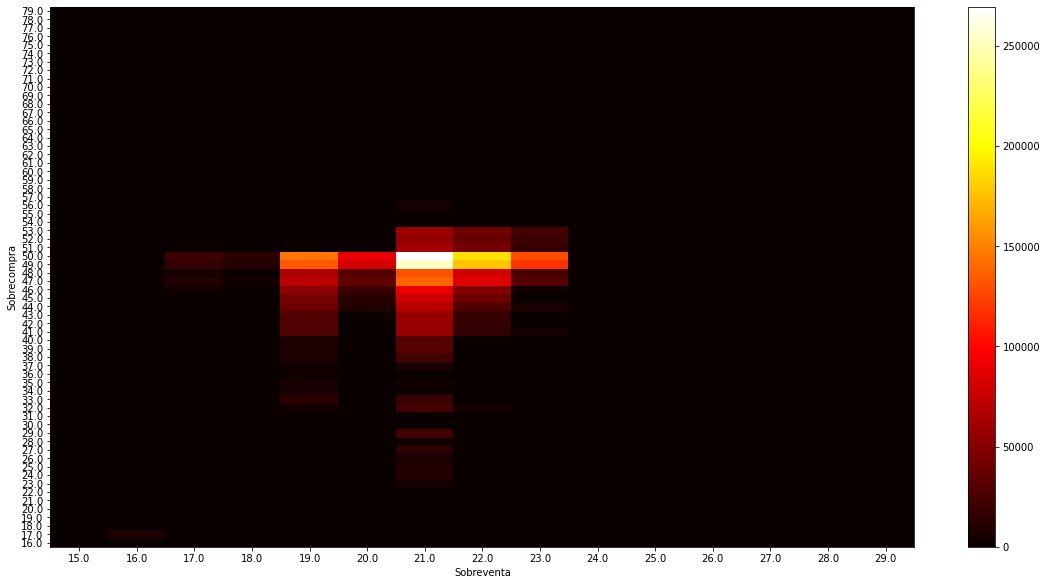


Calculando estrategia para  BBAR.BA
27 79 647385.8662842072


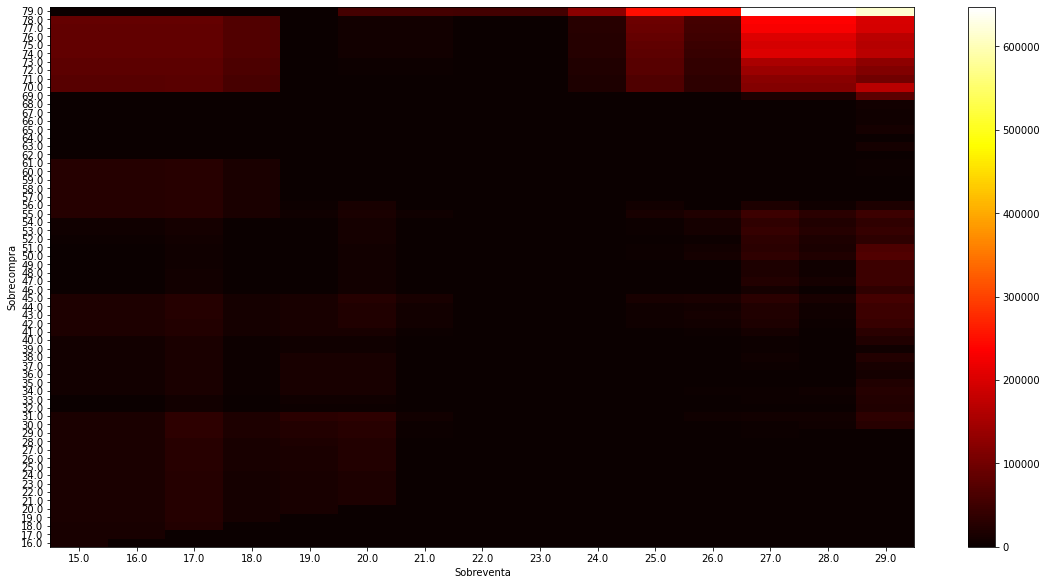


Calculando estrategia para  BMA.BA
25 26 236981.4076965954


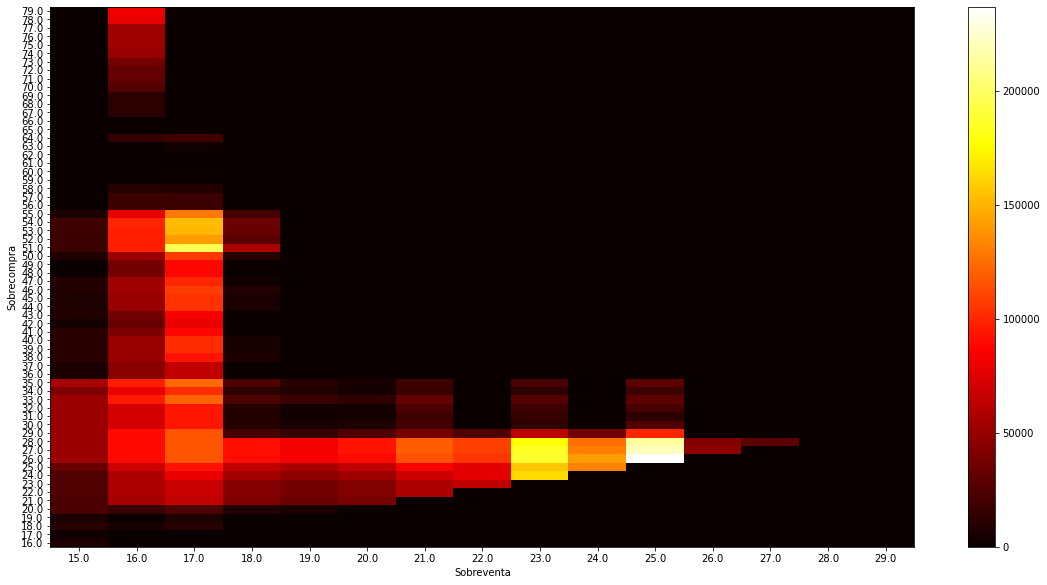


Calculando estrategia para  SUPV.BA
27 29 88235.69188607922


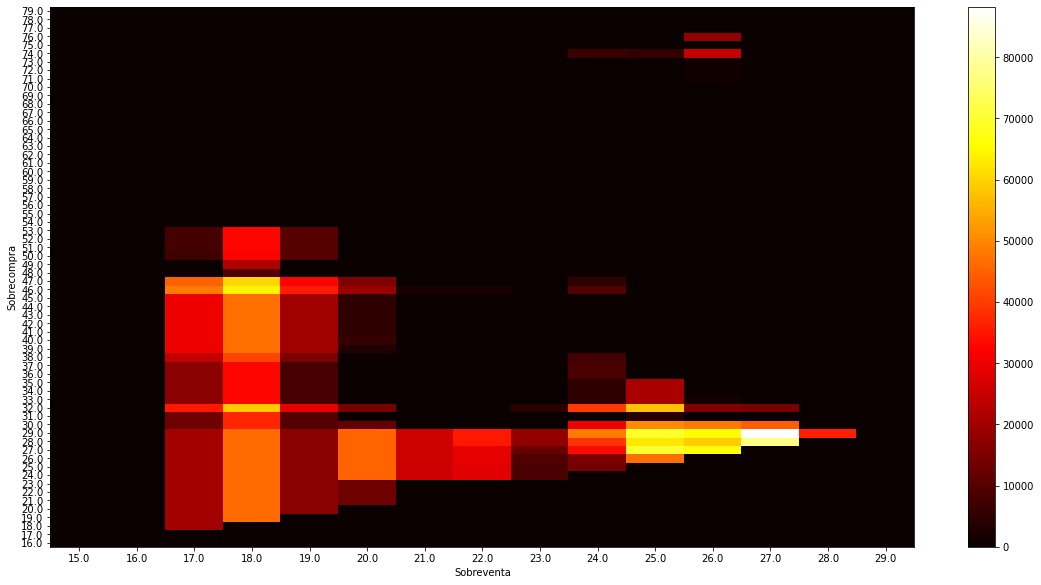


Calculando estrategia para  BYMA.BA
23 24 61657.18961652406


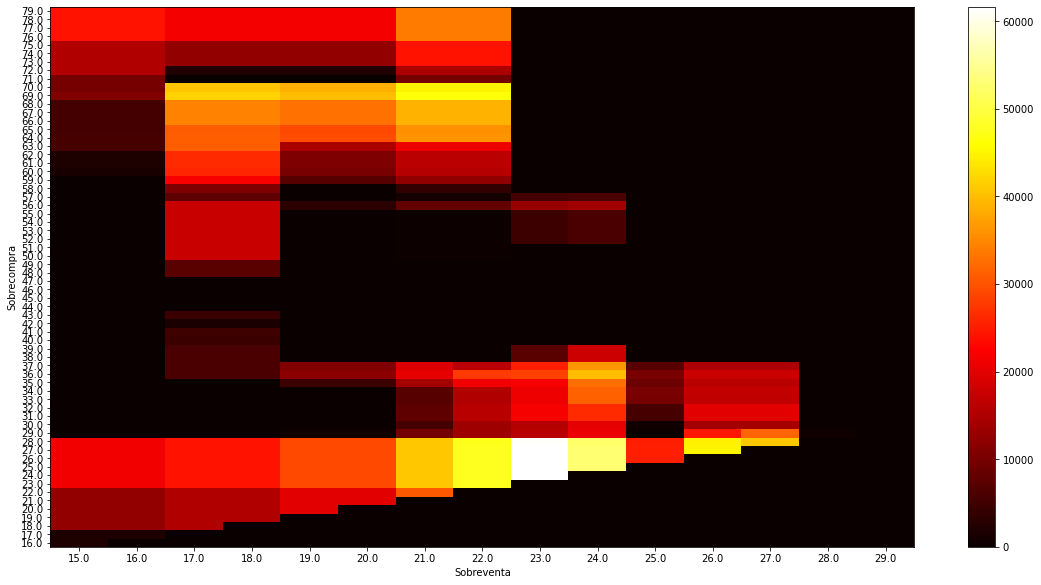


Calculando estrategia para  VALO.BA
20 79 169471.62621958484


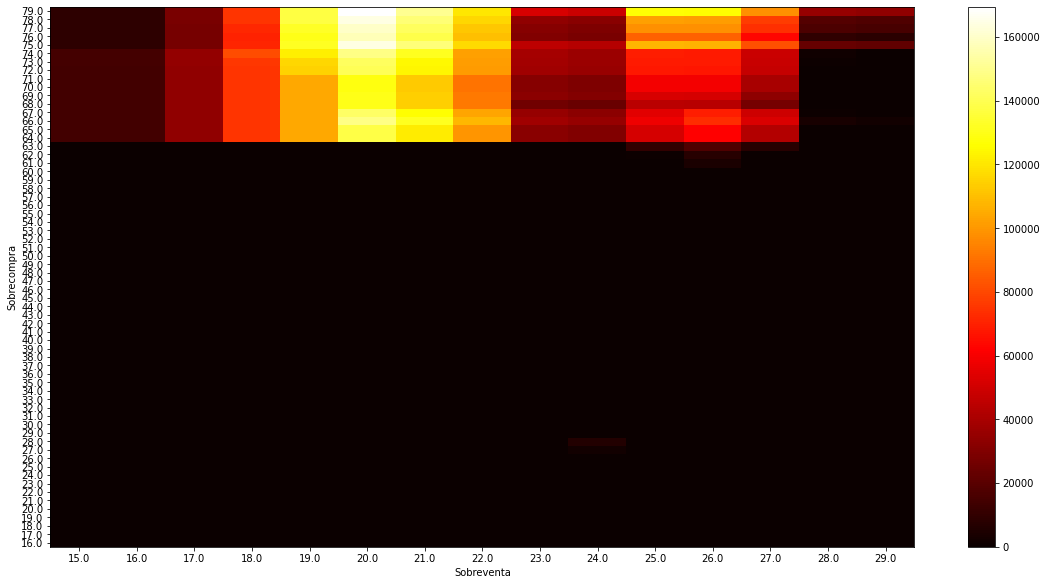


Calculando estrategia para  CVH.BA
27 41 38167.280933509326


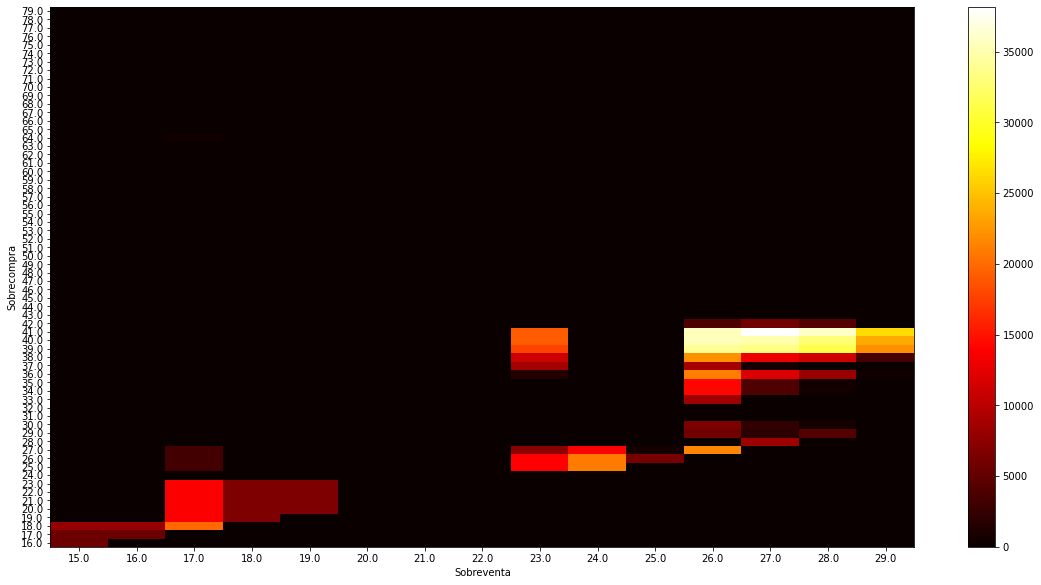


Calculando estrategia para  TECO2.BA
19 22 27156.636773487502


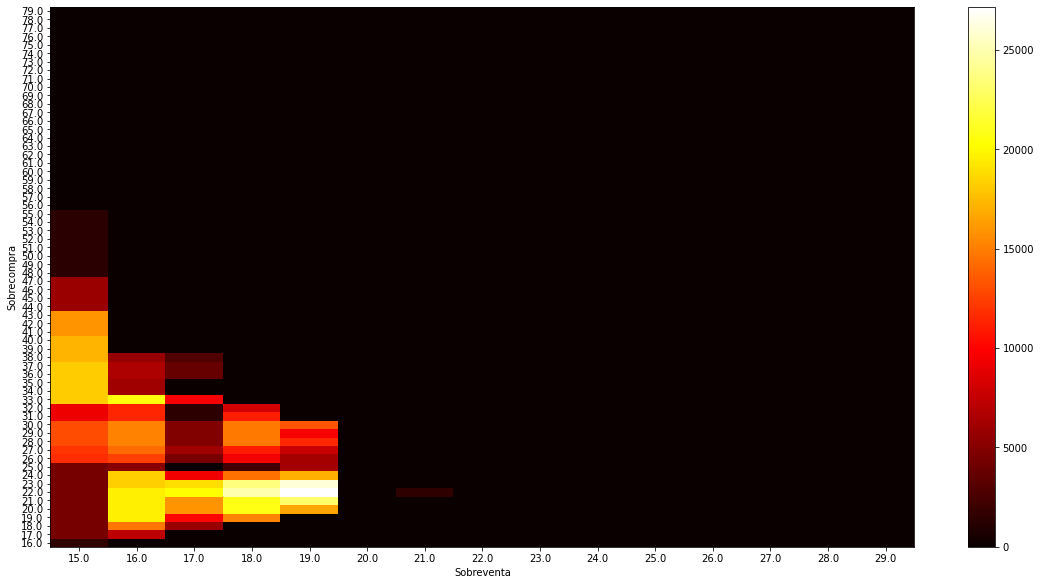


Calculando estrategia para  MIRG.BA
24 76 41695.8237155279


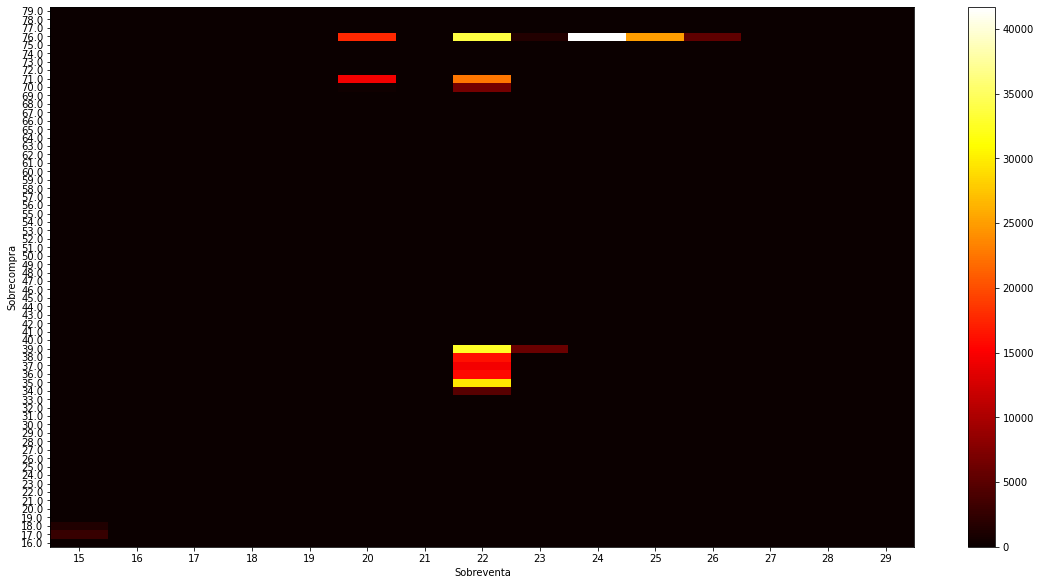


Calculando estrategia para  COME.BA
29 42 808352.8000768274


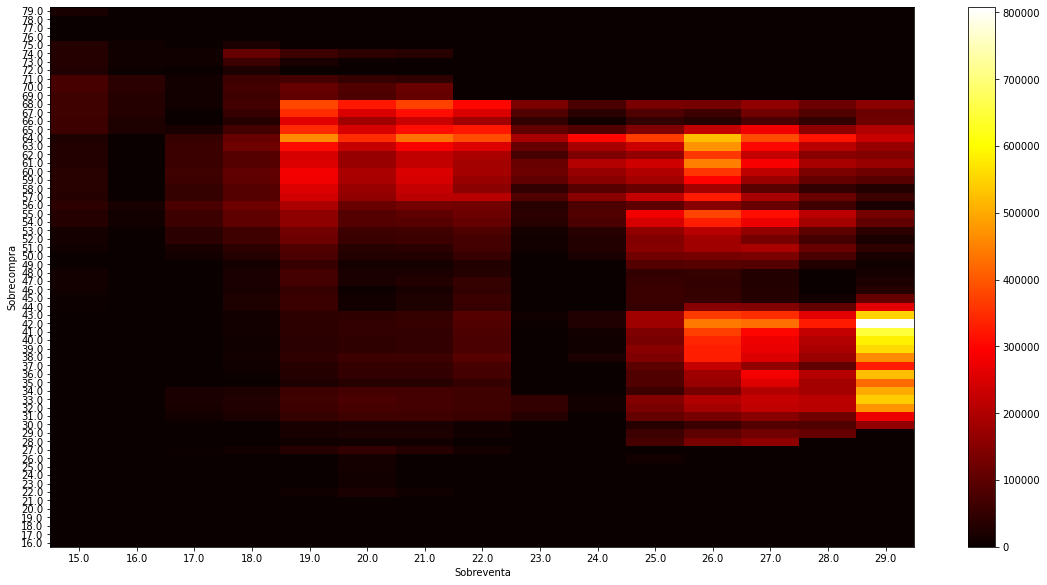


Calculando estrategia para  CRES.BA
24 64 645668.6802913648


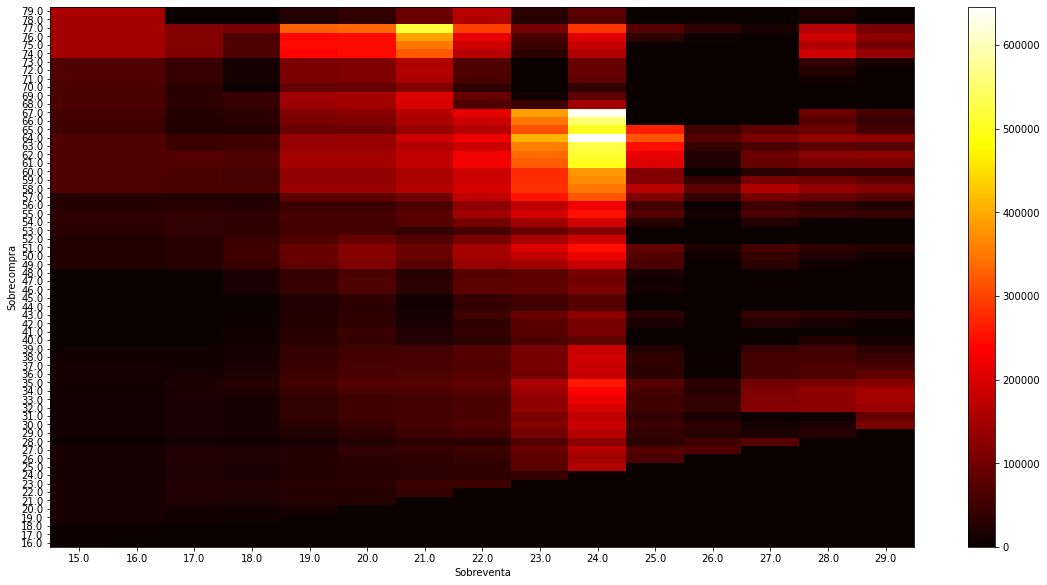


Calculando estrategia para  ALUA.BA
25 79 477851.2930953979


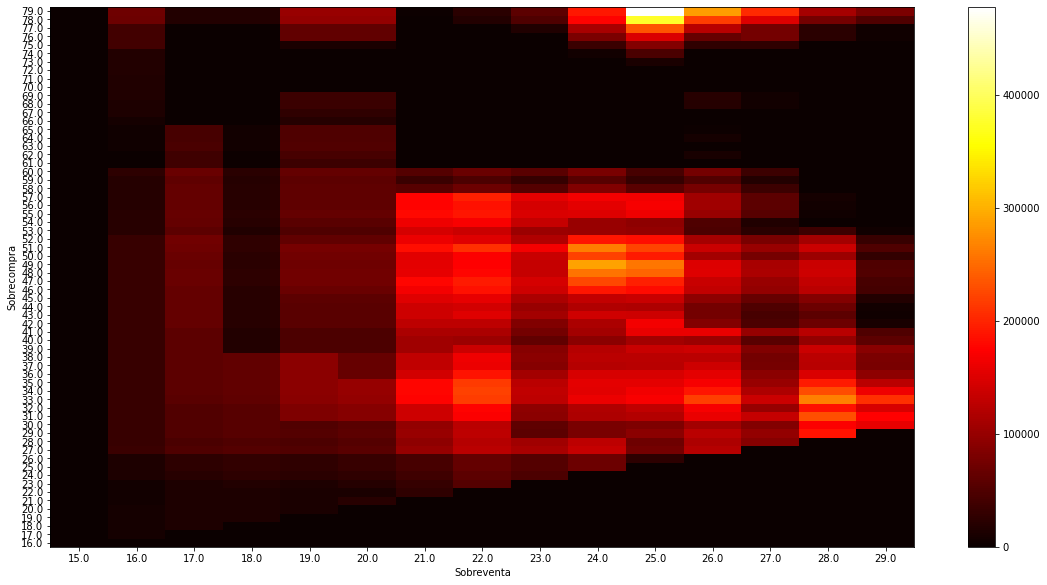


Calculando estrategia para  HARG.BA
17 30 23644.029214313818


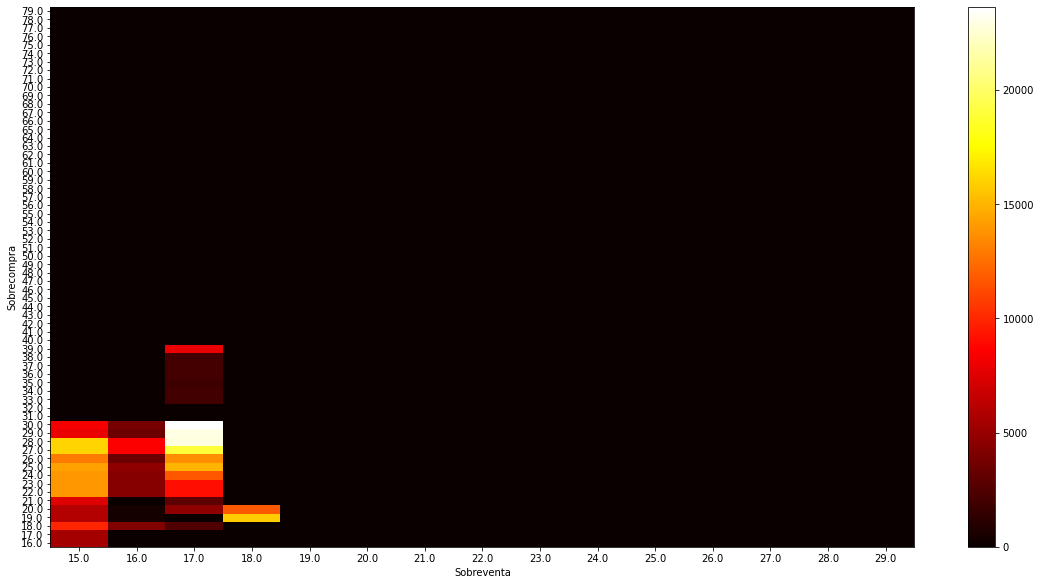


Calculando estrategia para  LOMA.BA
21 27 57202.16413547404


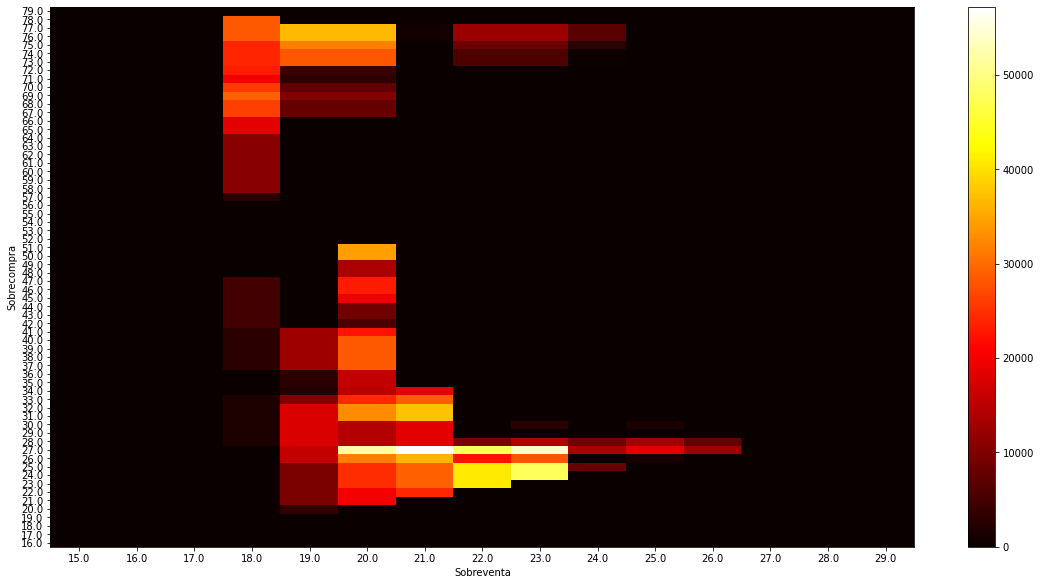


Calculando estrategia para  TXAR.BA
23 72 2330662.5396764306


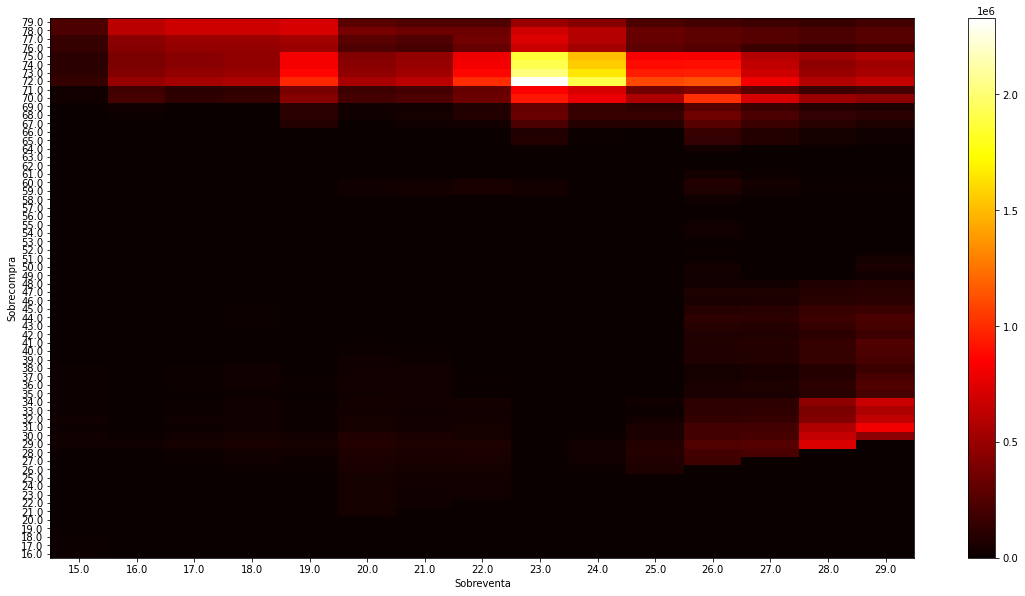


Calculando estrategia para  EDN.BA
15 45 48140.63256447243


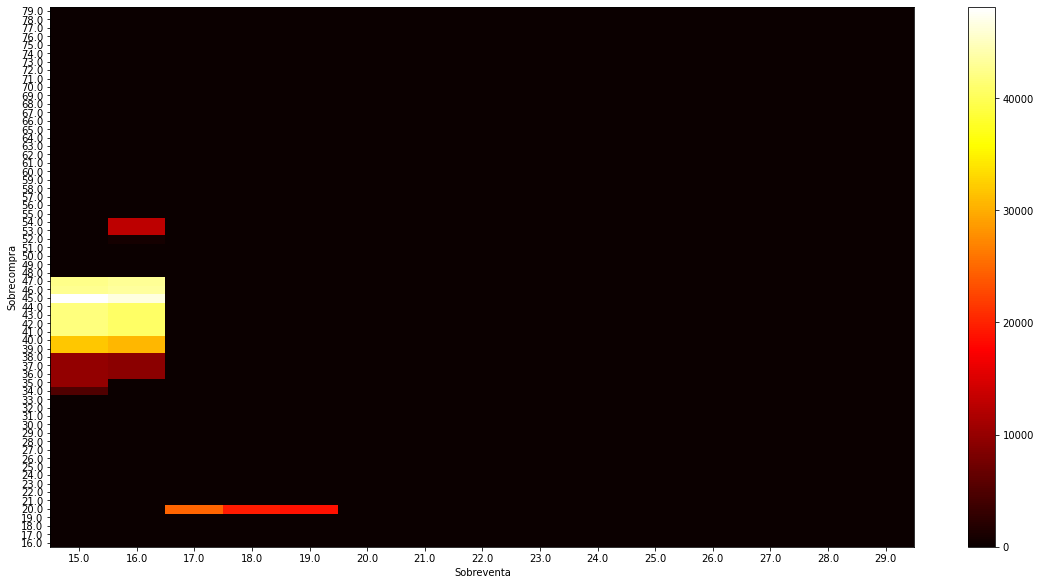


Calculando estrategia para  TGSU2.BA
26 28 87825.48566059474


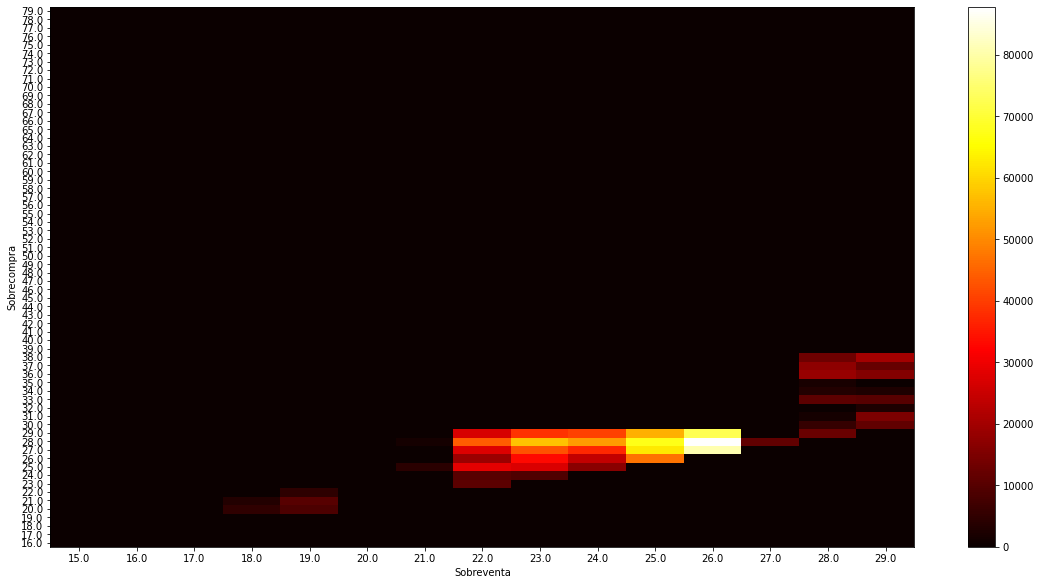


Calculando estrategia para  TGNO4.BA
22 62 435223.5349731894


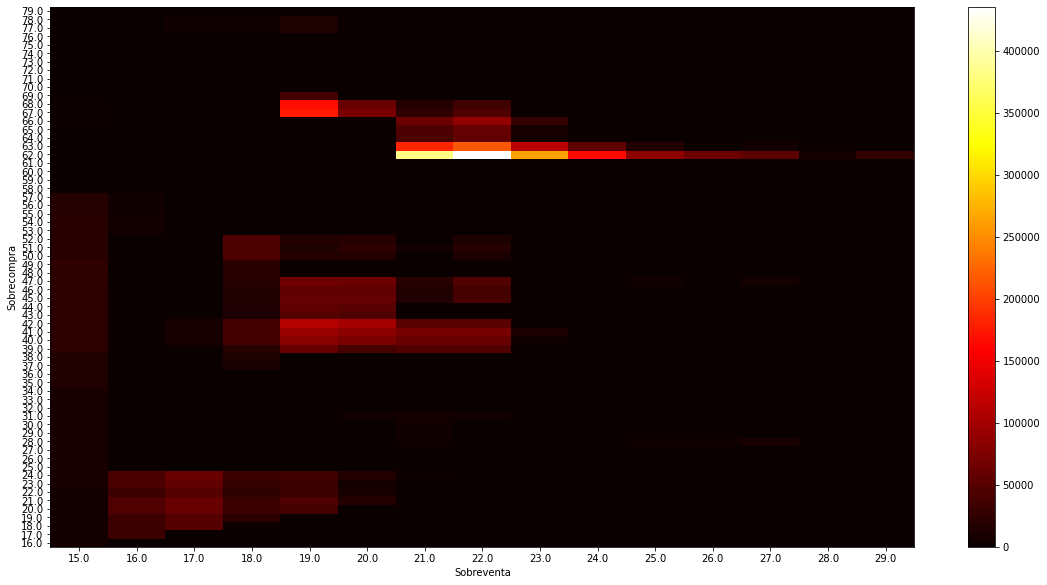


Calculando estrategia para  PAMP.BA
25 57 794545.7157356766


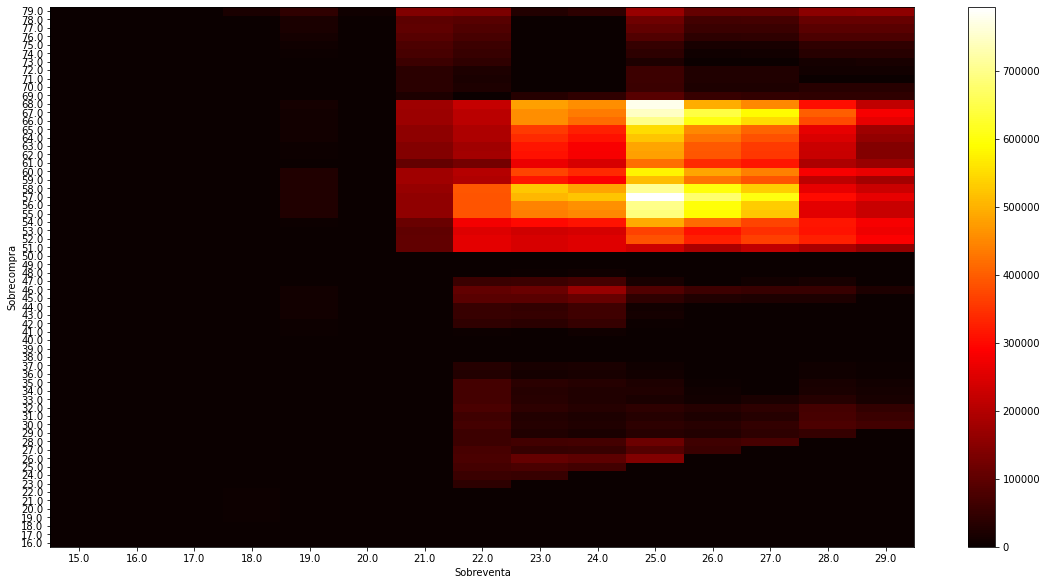


Calculando estrategia para  TRAN.BA
0 0 0


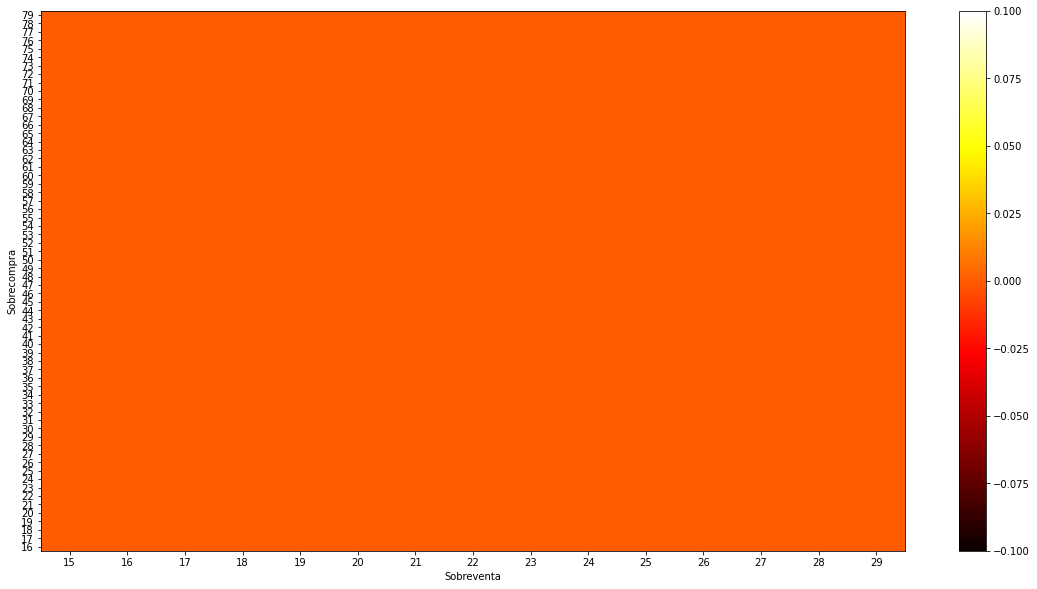


Calculando estrategia para  YPFD.BA
18 72 607023.5741162744


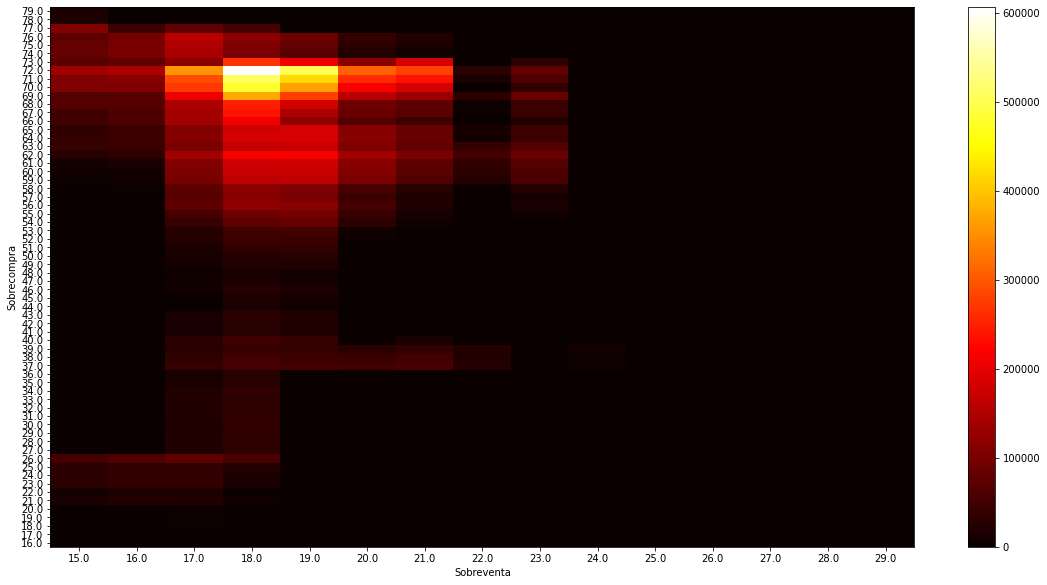

In [69]:
for ticker in tickers:
  result = 0
  sc_max = 0
  sv_max = 0
  result_max = 0
  trade_conv = pd.DataFrame(columns = ['sc', 'sv', 'profit'])
  print("\nCalculando estrategia para ",ticker)
  for sv in range(15, 30):
    for sc in range(sv+1, 80):
      result = calc_strategy_rsi(price_dict[ticker], sv, sc, variable)
      if result < 0.0:
        result = 0.0
      trade_conv = trade_conv.append({'sc': sc, 'sv': sv, 'profit': result}, ignore_index=True)
      if result > result_max:
        result_max = result
        sc_max = sc
        sv_max = sv
  print(sv_max, sc_max, result_max)

  #Transpolo la tabla
  trade_conv = trade_conv.set_index('sc', True)
  trade_conv = trade_conv.pivot(columns='sv', values='profit')
  trade_conv.fillna(0, inplace=True)

  # Create figure and set axes for subplots
  fig = plt.figure()
  fig.set_size_inches((15, 15))
  ax = fig.add_axes((0, 1.00, 1, 0.5))

  cs = ax.pcolor(trade_conv, cmap=plt.cm.hot)
  plt.yticks(np.arange(0.5, len(trade_conv.index), 1), trade_conv.index)
  plt.xticks(np.arange(0.5, len(trade_conv.columns), 1), trade_conv.columns)
  fig.colorbar(cs)
  ax.set_ylabel("Sobrecompra")
  ax.set_xlabel("Sobreventa")
  plt.show()